# E-11-뉴스 요약봇 만들기 프로젝트

### 텍스트 요약(Text Summarization)  
* 추출적 요약(Extractive Summarization) : 원문에서 문장들을 추출해서 요약하는 방식  
* 추상적 요약(Abstractive Summarization) : 원문으로부터 내용이 요약된 새로운 문장을 생성해내는 것, 새로운 문장이라는 것은 결과로 나온 문장이 원문에 원래 없던 문장일 수도 있다는 것을 의미  
  
### 인공 신경망으로 텍스트 요약 훈련시키기  
* seq2seq 모델을 이용하여 Abstractive summarization 방식의 텍스트 요약기 만들기  
  
#### seq2seq  
* LSTM과 컨텍스트 벡터 : seq2seq 구현 시, 인코더/디코더로 바닐라 RNN이 아닌 LSTM 사용  
* 시작 토큰과 종료 토큰 : 훈련 데이터의 예측 대상 시퀀스의 앞/뒤에는 시작 토큰과 종료 토큰을 넣어주는 전처리를 통해 어디에서 멈춰야하는지 알려줘야 함  
* 어텐션 메커니즘을 통한 새로운 컨텍스트 벡터 사용하기  
  
### 위 내용 요약 정리  
   1. seq2seq를 사용합니다.  
   2. RNN 계열 중 LSTM을 사용하므로 hidden state뿐만 아니라 cell state도 사용해야 합니다.  
   3. 디코더의 예측 시퀀스에는 시작 토큰 SOS와 예측 토큰 EOS를 시퀀스의 앞, 뒤로 붙입니다.  
   4. seq2seq를 구동시키면 디코더는 시작 토큰을 입력받아 예측을 시작합니다.  
   5. seq2seq 기본 모델과 달리, 어텐션 메커니즘을 이용해 인코더의 hidden state의 중요도를 취합한 컨텍스트 벡터를 디코더 스텝별로 계산합니다.  
   6. 계산된 컨텍스트 벡터를 이용해서 디코더는 다음 등장할 단어를 예측합니다.

# 프로젝트: 뉴스기사 요약해보기

## Step 1. 데이터 수집하기  
* 링크에 있는 뉴스 기사 데이터(newssummarymore.csv)를 사용 : https://github.com/sunnysai12345/
* 또는 아래 코드로 다운

In [1]:
# 데이터를 다운로드

import pandas as pd
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")

('news_summary_more.csv', <http.client.HTTPMessage at 0x7f408819ba10>)

## Step 2. 데이터 확인 및 전처리 (추상적 요약)  
실습에서 사용된 전처리를 참고하여 각자 필요하다고 생각하는 전처리를 추가 사용하여 텍스트를 정규화 또는 정제해 보세요. 만약, 불용어 제거를 선택한다면 상대적으로 길이가 짧은 요약 데이터에 대해서도 불용어를 제거하는 것이 좋을지 고민해보세요.  
* NLTK의 불용어(stopwords)를 사용 : NTLK와 NLTK 데이터셋이 설치되어있지 않은 환경이라면 NLTK를 설치하고 NTLK의 데이터셋을 다운로드
* NTLK 다운로드 : `pip install nltk`  
* BeautifulSoup 라이브러리(문서를 파싱하는데 사용하는 패키지) 설치 : `pip install beautifulsoup4`

### (1) 데이터 정리

In [2]:
# nltk 패키지에서 불용어 사전을 다운로드 받고, 데이터 전처리를 위한 나머지 패키지도 함께 불러오기

import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request

[nltk_data] Downloading package stopwords to /home/aiffel-
[nltk_data]     dj42/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


* `csv`파일 `headlines column`에 이름 붙이기 : https://rfriend.tistory.com/250

In [3]:
# 링크에서 다운로드 받은 데이터(Reviews.csv)에는 총 98401개의 샘플 있음
# 주의!! : 데이터 파일의 경로를 수정하는 것 잊지 말기

data = pd.read_csv(os.getenv("HOME")+"/aiffel/news_summarization/data/news_summary_more.csv",
                   names=['headlines', 'text'], header=None, encoding='iso-8859-1')
                   # headlines index이름 붙여주기-원본데이터 읽어올 때 key error
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 98402


In [4]:
print(data.columns)

Index(['headlines', 'text'], dtype='object')


In [5]:
#랜덤한 15개 샘플 출력
#data.sample(15)

#상위 5개 샘플 출력
data.head()

,headlines,text
0,headlines,text
1,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
2,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
3,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
4,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."


* text 입력 받아서 headlines 예측??

In [6]:
# 데이터의 중복 샘플 유무 확인

print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

# text가 달라도 headline은 동일할 수 있음
# 하지만 text 자체가 중복된 경우는 중복 샘플이므로 제거해야 함

text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280


In [7]:
# 데이터프레임의 drop_duplicates()를 사용하여 중복 샘플 제거

data.drop_duplicates(subset = ['text'], inplace = True)
print('전체 샘플수 :',(len(data)))

# 그런데 만약 데이터 Null값을 가지는 샘플이 있었다면, drop_duplicates()가 중복된 Null들을 지워주기는 하겠지만,
# 여전히 Null값 한개가 어딘가 남아있을 수 있음

전체 샘플수 : 98360


In [8]:
# 데이터프레임에 Null 값이 있는지 확인 : .isnull().sum()을 사용

print(data.isnull().sum())

headlines    0
text         0
dtype: int64


In [9]:
# 데이터프레임에서 Null 제거 : dropna() 함수 사용

data.dropna(axis = 0, inplace = True)
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 98360


#### 텍스트 정규화와 불용어 제거  
* 텍스트 정규화(text normalization) : 단어들 중 같은 의미 다른 표현들을 (예 : it'll/it will, mustn't/must not) 기계 학습 전에 미리 같은 표현으로 통일시켜 기계의 연산량 줄이기  
* 정규화 사전 출처 : https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python

In [10]:
# 텍스트 정규화를 위한 사전(dictionary) 구성

contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ",len(contractions))

정규화 사전의 수:  120


In [11]:
# 샘플에서 불용어를 제거 : NLTK에서 제공하는 불용어 리스트를 참조

print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [12]:
# 데이터 전처리 함수

def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    #sentence = re.sub(r"'s\b","",sentence) # 소유격 제거. Ex) roland's -> roland
    #sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    #sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [13]:
# 전처리 전, 후의 결과를 확인하기 위해 임의의 text와 headline를 만들어 함수를 호출
# (코드 오류가 난다면 parser가 설치되어있지 않은 것이니, lxml을 설치 : pip install lxml)

temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_headlines = 'Great way to start (or finish) the day!!!'

print(preprocess_sentence(temp_text))
print(preprocess_sentence(temp_headlines, False))  # 불용어를 제거하지 않습니다.

# 결과 : 모두 소문자로 변환, html 태그 제거, 괄호나 특수문자 제거

everything bought great, infact ordered twice third ordered wasfor mother father.
great way to start the day!!!


In [14]:
# 훈련 데이터 전체에 전처리 수행
# 이때, text의 경우 불용어 제거하고, headlines의 경우 불용어를 제거하지 않을 것이므로 따로 호출하여 진행
# 먼저 text를 전처리하고, 결과를 확인하기 위해서 상위 5개의 줄을 출력해보기

clean_text = []

# 전체 text 데이터에 대한 전처리 : 시간 오래 걸릴 수 있음 
for s in data['text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
clean_text[:5]

['text',
 "saurav kant, alumnus upgrad iiit-b's pg program machine learning artificial intelligence, sr systems engineer infosys almost years work experience. program upgrad's 360-degree career support helped transition data scientist tech mahindra 90% salary hike. upgrad's online power learning powered lakh+ careers.",
 "kunal shah's credit card bill payment platform, cred, gave users chance win free food swiggy one year. pranav kaushik, delhi techie, bagged reward spending 2000 cred coins. users get one cred coin per rupee bill paid, used avail rewards brands like ixigo, bookmyshow, ubereats, cult.fit more.",
 "new zealand defeated india wickets fourth odi hamilton thursday win first match five-match odi series. india lost international match rohit sharma's captaincy 12 consecutive victories dating back march 2018. match witnessed india getting 92, seventh lowest total odi cricket history.",
 'aegon life iterm insurance plan, customers enjoy tax benefits premiums paid save ã¢â\x82â¹4

In [15]:
# 이제 headlines에 대해서 전처리 함수를 호출해줄 때, 불용어 제거를 수행하지 않는다는 의미에서 두번째 인자로 False를 넣어주기

clean_headlines = []

# 전체 headlines 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다. 
for s in data['headlines']:
    clean_headlines.append(preprocess_sentence(s, False))

clean_headlines[:5]

# 텍스트 정제 과정을 거친 후, 다시 한번 빈(empty) 샘플이 생겼는지 확인
# 정제 전에는 데이터가 존재했지만, 정제 과정에서 문장의 모든 단어가 사라지는 경우가 있을 수 있음
# 이렇게 되면 샘플 자체가 빈 값을 가지게 됨

['headlines',
 'upgrad learner switches to career in ml al with 90% salary hike',
 'delhi techie wins free food from swiggy for one year on cred',
 "new zealand end rohit sharma-led india's 12-match winning streak",
 'aegon life iterm insurance plan helps customers save tax']

In [16]:
# 쉽게 확인하기 위해 데이터들을 데이터프레임에 재저장하고 빈(empty) 값을 갖는 샘플들은 모두 Null 값을 가진 샘플로 대체

data['text'] = clean_text
data['headlines'] = clean_headlines

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

In [17]:
# .isnull().sum()을 사용하여 Null 값이 생겼는지 확인

data.isnull().sum()

# headlines 열에서 70개의 Null 값이 생성
# 원래는 단어가 있었는데, 정제 과정에서 모든 단어가 제거되어 빈 샘플이 70개 생겼다는 의미

headlines    0
text         0
dtype: int64

In [18]:
# Null 샘플들 모두 제거

data.dropna(axis=0, inplace=True)
print('전체 샘플수 :',(len(data)))  #데이터 전처리 함수

전체 샘플수 : 98360


### (2) 훈련데이터와 테스트데이터 나누기  
* 학습에 사용할 데이터의 크기를 결정하고, 문장의 시작과 끝 표시하기

#### 샘플 최대 길이 정하기

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 64
텍스트의 평균 길이 : 35.881659211061404
헤드라인의 최소 길이 : 1
헤드라인의 최대 길이 : 16
헤드라인의 평균 길이 : 9.42547783651891


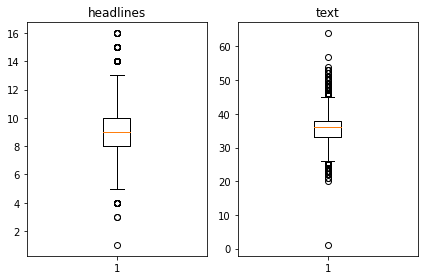

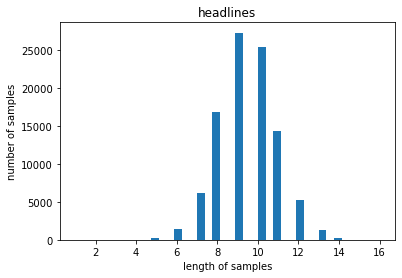

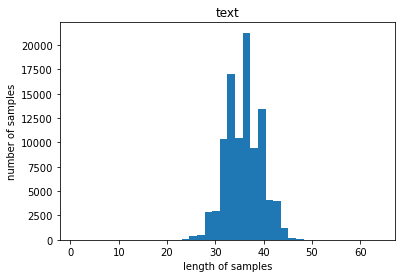

In [19]:
# text와 headlines의 최소, 최대, 평균 길이를 구하고 길이 분포를 시각화하여 확인

# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('헤드라인의 최소 길이 : {}'.format(np.min(headlines_len)))
print('헤드라인의 최대 길이 : {}'.format(np.max(headlines_len)))
print('헤드라인의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('text')
plt.tight_layout()
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [20]:
# text의 최대 길이와 headlines의 적절한 최대 길이 임의로 정해보기

text_max_len = 50
headlines_max_len = 16

# 이 길이를 선택했을 때, 얼마나 많은 샘플들을 자르지 않고 포함할 수 있는지 통계로 확인하는 편이 객관적으로 길이를 결정하는데 도움이 될 것임

In [21]:
# 좀 더 정확한 판단을 위하여, 훈련 데이터와 샘플의 길이를 입력하면 데이터의 몇 %가 해당하는지 계산하는 함수 만들기

def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [22]:
# 함수를 text와 headlines에 적용해 우리가 결정한 임의의 길이가 몇%의 샘플까지 포함하는지 확인해 보기

below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len,  data['headlines'])

# 결과 : 각각 50과 8로 패딩을 하게되면 해당 길이보다 긴 샘플들은 내용이 잘리게 되는데,
# text 열의 경우에는 약 23%의 샘플들이 내용이 망가지게 된다함

전체 샘플 중 길이가 50 이하인 샘플의 비율: 0.9998373322488816
전체 샘플 중 길이가 16 이하인 샘플의 비율: 1.0


In [23]:
# 정해진 길이에 맞춰 자르는 것이 아니라, 정해진 길이보다 길면 제외하는 방법으로 데이터를 정제

data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 98344


#### 시작 토큰과 종료 토큰 추가하기

In [24]:
# 시작 토큰은 'sostoken', 종료 토큰은 'eostoken'이라 임의로 명명하고 앞, 뒤로 추가
# 디코더의 입력에 해당하면서 시작 토큰이 맨 앞에 있는 문장의 이름을 decoder_input,
# 디코더의 출력 또는 레이블에 해당되면서 종료 토큰이 맨 뒤에 붙는 문장의 이름을 decoder_target이라고 하기
# 두 개의 문장 모두 Summary 열로부터 만들 것임

#요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,headlines,text,sostoken headlines,headlines eostoken
1,upgrad learner switches to career in ml al wit...,"saurav kant, alumnus upgrad iiit-b's pg progra...",sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
2,delhi techie wins free food from swiggy for on...,kunal shah's credit card bill payment platform...,sostoken delhi techie wins free food from swig...,delhi techie wins free food from swiggy for on...
3,new zealand end rohit sharma-led india's 12-ma...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma-led indi...,new zealand end rohit sharma-led india's 12-ma...
4,aegon life iterm insurance plan helps customer...,"aegon life iterm insurance plan, customers enj...",sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...


In [25]:
# 인코더의 입력, 디코더의 입력과 레이블을 각각 다시 Numpy 타입으로 저장

encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

In [26]:
# 훈련 데이터와 테스트 데이터 분리 : 분리 패키지를 사용하는 방법과 직접 코딩을 통해서 분리하는 방법 중 직접 코딩하여 분리

# 1. encoder_input과 크기 및 형태가 같은 순서가 섞인 정수 시퀀스 만들기

indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[74169  9441 91085 ...  7337 65841 18472]


In [27]:
# 이 정수 시퀀스를 이용해 다시 데이터의 샘플 순서를 정의해주어 잘 섞인 샘플 만들기

encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [28]:
# 섞인 데이터를 8:2의 비율로 훈련 데이터와 테스트 데이터로 분리

n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :',n_of_val)

테스트 데이터의 수 : 19668


In [29]:
# 테스트 데이터의 개수를 이용하여 전체 데이터 분할
# :표시의 위치에 주의

encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

훈련 데이터의 개수 : 78676
훈련 레이블의 개수 : 78676
테스트 데이터의 개수 : 19668
테스트 레이블의 개수 : 19668


### (3) 정수 인코딩

#### 단어 집합(vocaburary) 만들기 및 정수 인코딩

In [30]:
# 훈련 데이터에 대해서 단어 집합을 만들어보기
# 우선, 원문에 해당되는 encoder_input_train에 대해서 단어 집합을 만들기
# Keras의 토크나이저를 사용하면, 입력된 훈련 데이터로부터 단어 집합을 만들 수 있음

src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

# 이제 단어 집합이 생성되는 동시에 각 단어에 고유한 정수 부여
# 현재 생성된 단어 집합은 src_tokenizer.word_index에 저장되어있음
# 이렇게 만든 단어 집합에 있는 모든 단어를 사용하는 것이 아니라, 빈도수가 낮은 단어들은 훈련 데이터에서 제외하고 진행할 것임

In [31]:
# 등장 빈도수가 7회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인
# src_tokenizer.word_counts.items()에는 단어와 각 단어의 등장 빈도수가 저장되어져 있는데, 이를 통해 통계적인 정보를 얻음

threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)   # encoder_input_train에 있는 총 단어수
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 90560
등장 빈도가 6번 이하인 희귀 단어의 수: 65961
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 24599
단어 집합에서 희귀 단어의 비율: 72.83679328621908
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.3125090691818535


In [32]:
# 등장 빈도가 6회 이하인 단어들은 정수 인코딩 과정에서 빼고, 훈련 데이터에서 제거
# 위에서 이를 제외한 단어 집합의 크기가 대략 8000 안팍으로 계산되는데, 이와 비슷한 값으로 어림잡아 단어 집합의 크기를 8000으로 제한
# 토크나이저를 정의할 때 num_words의 값을 정해주면, 단어 집합의 크기를 제한할 수 있음

src_vocab = 8000
src_tokenizer = Tokenizer(num_words = src_vocab) # 단어 집합의 크기를 8,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성.

In [33]:
# texts_to_sequences()는 생성된 단어 집합에 기반하여 입력으로 주어진 텍스트 데이터의 단어들을 모두 정수로 변환하는 정수 인코딩 수행
# 현재 단어 집합의 크기를 8,000으로 제한했으니까 이제 8,000이 넘는 숫자들은 정수 인코딩 후에 데이터에 존재하지 않음

# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

#잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

# 결과 : 텍스트를 정수로 바꿨으니까 정수로 출력

[[1822, 291, 298, 3370, 352, 380, 654, 85, 2889, 2870, 618, 61, 47, 160, 122, 47, 2, 452, 1820, 79, 163, 161, 35, 80, 1206, 1095, 20, 149, 4949, 22, 2889, 201, 1021, 298], [2103, 1, 2534, 245, 6, 2668, 329, 2472, 453, 30, 42, 376, 1644, 109, 6, 422, 5765, 1086, 4990, 823, 1332, 811, 410, 3, 1, 6113, 1001, 245, 2103, 430, 478], [436, 37, 91, 6539, 48, 86, 908, 276, 1087, 1739, 665, 1185, 350, 55, 37, 491, 789, 10, 1185, 564, 6258, 630, 316, 65, 500, 300, 1272, 6631, 209, 52, 2708, 350, 1185, 276, 1087, 1394]]


In [34]:
# headlines 데이터에 대해서도 동일한 작업 수행
# 케라스의 토크나이저를 사용하여 decoder_input_train을 입력으로 전체 단어 집합과 각 단어에 대한 빈도수를 계산

tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

# 단어 집합이 생성되는 동시에 각 단어에 고유한 정수가 부여되고 이는 tar_tokenizer.word_index에 저장
# tar_tokenizer.word_counts.items()에는 단어와 각 단어의 등장 빈도수가 저장

In [35]:
# 이를 통해서 통계적인 정보를 얻어서, 등장 빈도수가 6회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인

threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 40658
등장 빈도가 5번 이하인 희귀 단어의 수: 29380
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 11278
단어 집합에서 희귀 단어의 비율: 72.2613015888632
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 6.199318941696273


In [36]:
# 위와 마찬가지로 등장빈도가 적은 희귀 단어들(대략 2000개) 제거 : 단어집합 크기 제한

tar_vocab = 2000
tar_tokenizer = Tokenizer(num_words = tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

#잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 165, 6, 236, 17, 416], [1, 43, 226, 8, 15, 13, 1847, 3, 352, 1003, 364, 1320], [1, 126, 16, 510, 362, 4, 1113], [1, 1740, 42, 89, 93, 4, 577, 10, 344, 55], [1, 33, 441, 724, 450, 243, 657, 637]]
target
decoder  [[165, 6, 236, 17, 416, 2], [43, 226, 8, 15, 13, 1847, 3, 352, 1003, 364, 1320, 2], [126, 16, 510, 362, 4, 1113, 2], [1740, 42, 89, 93, 4, 577, 10, 344, 55, 2], [33, 441, 724, 450, 243, 657, 637, 2]]


##### 패딩 작업 전 점검 사항  
전체 데이터에서 빈도수가 낮은 단어가 삭제되었다는 것은 빈도수가 낮은 단어만으로 구성되었던 샘플들은 이제 빈(empty) 샘플이 되었을 가능성이 있어요. 이 현상은 길이가 상대적으로 길었던 원문(Text)의 경우에는 문제가 별로 없겠지만, 애초에 평균 길이가 4밖에 되지 않았던 요약문(Summary)의 경우에는 이 현상이 굉장히 두드러졌을 가능성이 높겠죠.  
  
요약문에서 길이가 0이 된 샘플들의 인덱스를 받아와볼게요. 여기서 주의할 점은 요약문인 decoder_input에는 sostoken 또는 decoder_target에는 eostoken이 추가된 상태이고, 이 두 토큰은 모든 샘플에서 등장하므로 빈도수가 샘플수와 동일하게 매우 높으므로 단어 집합 제한에도 삭제 되지 않아요. 그래서 이제 길이가 0이 된 요약문의 실제길이는 1로 나올거에요. 길이 0이 된 decoder_input에는 sostoken, decoder_target에는 eostoken만 남아 있을테니까요.

In [37]:
# 훈련 데이터와 테스트 데이터에서 요약문의 길이가 1인 경우의 인덱스를 각각 drop_train과 drop_test에 라는 변수에 저장
# 이 샘플들은 모두 삭제

drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :',len(drop_train))
print('삭제할 테스트 데이터의 개수 :',len(drop_test))

encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)
decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)
decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 17
삭제할 테스트 데이터의 개수 : 5
훈련 데이터의 개수 : 78659
훈련 레이블의 개수 : 78659
테스트 데이터의 개수 : 19663
테스트 레이블의 개수 : 19663


/home/aiffel-dj42/anaconda3/envs/aiffel/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


#### 패딩하기

In [38]:
# 텍스트 시퀀스를 정수 시퀀스로 변환 후, 서로 다른 길이의 샘플들을 병렬 처리하기 위해 같은 길이로 맞춰주는 패딩 작업 필요
# 아까 정해두었던 최대 길이로 패딩함
# 최대 길이보다 짧은 데이터들은 뒤의 공간에 숫자 0을 넣어 최대 길이로 길이를 맞춰주기

encoder_input_train = pad_sequences(encoder_input_train, maxlen = text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen = text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen = headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen = headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen = headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen = headlines_max_len, padding='post')

# 학습에 필요한 전처리 끝!!!!!

## Step 3. 어텐션 메커니즘 사용하기 (추상적 요약)  
일반적인 seq2seq보다는 어텐션 메커니즘을 사용한 seq2seq를 사용하는 것이 더 나은 성능을 얻을 수 있어요. 실습 내용을 참고하여 어텐션 메커니즘을 사용한 seq2seq를 설계해 보세요.

### (1) 모델 설계

In [39]:
# 함수형 API를 이용하여 인코더를 설계

from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [40]:
# 디코더 설계

decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences = True, return_state = True, dropout = 0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state = [state_h, state_c])

In [41]:
# 디코더의 출력층 설계
decoder_softmax_layer = Dense(tar_vocab, activation = 'softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 128)      1024000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 50, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

#### 어텐션 매커니즘  
* 어텐션 메커니즘을 수행하는 어텐션 함수를 설계하는 것은 또 다른 새로운 신경망을 설계해야한다는 뜻  
* 참고1 : https://wikidocs.net/73161  
* 참고2 : https://www.youtube.com/watch?v=WsQLdu2JMgI

In [42]:
# 깃허브에 공개되어져 있는 어텐션 함수를 다운로드

urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")
from attention import AttentionLayer

# 경로에 attention.py 파일이 생겼으니, 어텐션 메커니즘을 사용할 준비가 되었음

In [43]:
# 설계한 디코더의 출력층을 다음과 같이 수정

# 어텐션 층(어텐션 함수)
attn_layer = AttentionLayer(name='attention_layer')
# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis = -1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

# 위의 코드는 인코더의 hidden state들과 디코더의 hidden state들을 어텐션 함수의 입력으로 사용
# 어텐션 함수가 리턴한 값을 예측 시에 디코더의 hidden state와 함께 활용하는 형태로 작동

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 128)      1024000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 50, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

### (2) 모델 훈련

In [44]:
# 모델 훈련(학습)

model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

# EarlyStopping : 조기 종료, 특정 조건이 충족되면 모델의 훈련을 멈추는 역할
# 여기서는 val_loss(검증 데이터의 손실)을 모니터링 하면서, 검증 데이터의 손실이 줄어들지 않고 증가하는 현상이 patiensce =2
# 즉, 2회 관측되면 학습을 멈추도록 설정
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 2)

history = model.fit(x = [encoder_input_train, decoder_input_train], y = decoder_target_train, \
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size = 256, callbacks=[es], epochs = 50)

Epoch 1/50
308/308 [==============================] - 123s 398ms/step - loss: 2.9653 - val_loss: 2.7078
Epoch 2/50
308/308 [==============================] - 123s 398ms/step - loss: 2.5819 - val_loss: 2.4794
Epoch 3/50
308/308 [==============================] - 124s 402ms/step - loss: 2.3779 - val_loss: 2.3239
Epoch 4/50
308/308 [==============================] - 125s 406ms/step - loss: 2.2423 - val_loss: 2.2262
Epoch 5/50
308/308 [==============================] - 123s 400ms/step - loss: 2.1410 - val_loss: 2.1413
Epoch 6/50
308/308 [==============================] - 125s 405ms/step - loss: 2.0583 - val_loss: 2.0835
Epoch 7/50
308/308 [==============================] - 124s 404ms/step - loss: 1.9877 - val_loss: 2.0364
Epoch 8/50
308/308 [==============================] - 124s 401ms/step - loss: 1.9281 - val_loss: 1.9906
Epoch 9/50
308/308 [==============================] - 123s 401ms/step - loss: 1.8756 - val_loss: 1.9647
Epoch 10/50
308/308 [==============================] - 124s 401m

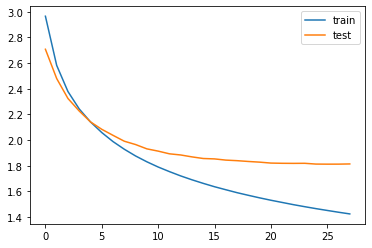

In [45]:
# 훈련 데이터의 손실과 검증 데이터의 손실이 줄어드는 과정을 시각화

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

### (3) 인퍼런스 모델 구현하기

In [46]:
# 테스트 단계에서 정수 인덱스 행렬로 존재하던 텍스트 데이터를 실제 데이터로 복원해야 하므로, 필요한 3개의 사전을 미리 준비

src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 헤드라인 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 헤드라인 단어 집합에서 정수 -> 단어를 얻음

##### seq2seq는 훈련할 때와 실제 동작할 때(인퍼런스 단계)의 방식이 다르므로 그에 맞게 모델 설계를 별개로 진행  
훈련 단계에서는 디코더의 입력부에 정답이 되는 문장 전체를 한꺼번에 넣고 디코더의 출력과 한번에 비교할 수 있으므로, 인코더와 디코더를 엮은 통짜 모델 하나만 준비  
  
그러나 정답 문장이 없는 인퍼런스 단계에서는 만들어야 할 문장의 길이만큼 디코더가 반복 구조로 동작해야 하기 때문에 부득이하게 인퍼런스를 위한 모델 설계를 별도로 해주어야 함  
  
이 때는 인코더 모델과 디코더 모델을 분리해서 설계

In [47]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)
# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [48]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [49]:
# 인퍼런스 단계에서 단어 시퀀스를 완성하는 함수 만들기

def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if(sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

## Step 4. 실제 결과와 요약문 비교하기 (추상적 요약) : 모델 테스트  
원래의 요약문(headlines 열)과 학습을 통해 얻은 추상적 요약의 결과를 비교해보세요.

In [50]:
# 주어진 정수 시퀀스를 텍스트 시퀀스로 변환하는 함수를 만들어 두기
# 1. text의 정수 시퀀스에서는 패딩을 위해 사용되는 숫자 0을 제외시키고
# 2. headlines의 정수 시퀀스에서는 숫자 0, 시작 토큰의 인덱스, 종료 토큰의 인덱스를 출력에서 제외

# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if(i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [51]:
# 테스트 데이터 약 50개의 샘플에 대해서 실제 요약과 예측된 요약을 비교

for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : us bank wells recently hit fraudulent accounts scandal said cutting 69 senior level executive jobs bank reduce number regional area presidents 91 current 160 bank facing another scandal charged many lakh customers auto insurance need 
실제 요약 : cuts top jobs post accounts scandal 
예측 요약 :  bank of bank accounts in


원문 : janata dal spokesperson said bihar chief minister nitish kumar would become manmohan singh upa 2 continued charges corruption surfaced tejashwi yadav slamming sharad yadav's stand said yadav bjp's support 1999 issue then 
실제 요약 : nitish would have become singh of 2 jd leader 
예측 요약 :  nitish kumar to be in


원문 : whistleblower suggested government must anyone uses aadhaar data purposes public services added penalty must introduced indian government serious aadhaar public good privacy issues helps violate it said 
실제 요약 : govt must anyone aadhaar data 
예측 요약 :  aadhaar must be mandatory for aadhaar


원문 : aap led delhi government tuesday asked supreme court whether c

예측 요약 :  foreign in


원문 : supreme court thursday agreed examine pleas filed congress leaders kamal nath sachin pilot alleging names poll bound madhya pradesh rajasthan also sought random verification machines apex court sought response election commission state election madhya pradesh rajasthan n 
실제 요약 : sc to of congress leaders on 
예측 요약 :  sc to plea against bjp for of


원문 : flipkart's co founder group ceo binny bansal interview recalled e commerce startup got name said sachin said letters available 8 less added spent hours domain names thought flipkart way said 
실제 요약 : flipkart group ceo reveals how the startup got its name 
예측 요약 :  am not an of the best ceo


원문 : million singing clock installed planned high speed railway station england work big art project winner station clock play 1 000 voices 12 musical sharp replace one 12 
실제 요약 : to come up at england railway station 
예측 요약 :  crore to be built in india


원문 : one leading indian newspapers slammed publishing ad section

## Step 5. Summa을 이용해서 추출적 요약해보기  
추상적 요약은 추출적 요약과는 달리 문장의 표현력을 다양하게 가져갈 수 있지만, 추출적 요약에 비해서 난이도가 높아요. 반대로 말하면 추출적 요약은 추상적 요약에 비해 난이도가 낮고 기존 문장에서 문장을 꺼내오는 것이므로 잘못된 요약이 나올 가능성이 낮아요.  
  
Summa의 summarize를 사용하여 추출적 요약을 해보세요.  
    
패키지 Summa에서는 추출적 요약을 위한 모듈인 summarize를 제공  
#### 패키지 설치  
* `pip install summa`

In [52]:
import requests
from summa.summarizer import summarize

In [53]:
import pandas as pd
text = pd.read_csv(os.getenv("HOME")+"/aiffel/news_summarization/data/news.csv")
print('전체 샘플수 :',(len(text)))

전체 샘플수 : 98401


In [54]:
# 뉴스 원문 일부 추출

print(text['text'])

0        Saurav Kant, an alumnus of upGrad and IIIT-B's...
1        Kunal Shah's credit card bill payment platform...
2        New Zealand defeated India by 8 wickets in the...
3        With Aegon Life iTerm Insurance plan, customer...
4        Speaking about the sexual harassment allegatio...
                               ...                        
98396    A CRPF jawan was on Tuesday axed to death with...
98397    'Uff Yeh', the first song from the Sonakshi Si...
98398    According to reports, a new version of the 199...
98399    A new music video shows rapper Snoop Dogg aimi...
98400    Madhesi Morcha, an alliance of seven political...
Name: text, Length: 98401, dtype: object


#### summarize 사용하기  
* text (str) : 요약할 테스트  
* ratio (float, optional) – 요약문에서 원본에서 선택되는 문장 비율. 0~1 사이값  
* words (int or None, optional) – 출력에 포함할 단어 수  
* 만약, ratio와 함께 두 파라미터가 모두 제공되는 경우 ratio는 무시  
* split (bool, optional) – True면 문장 list / False는 조인(join)된 문자열을 반환 

In [55]:
# Summa의 summarize는 문장 토큰화를 별도로 하지 않더라도 내부적으로 문장 토큰화를 수행
# 그렇기 때문에 문장 구분이 되어있지 않은 원문을 바로 입력으로 넣을 수 있음
# 비율을 적게 주어 요약문으로 선택되는 문장의 개수를 줄여보기
# 원문의 0.005%만을 출력하도록 설하

print('Summary:')
print(summarize(text['text'][0], ratio=0.5))

Summary:
upGrad's Online Power Learning has powered 3 lakh+ careers.


In [56]:
# 리스트로 출력 결과를 받고 싶으면 split 인자의 값을 True로 하기

print('Summary:')
print(summarize(text['text'][0], ratio=0.5, split=True))

Summary:
["upGrad's Online Power Learning has powered 3 lakh+ careers."]


In [57]:
# 단어의 수로 요약문의 크기를 조절 가능
# 단어를 50개만 선택하도록 설정

print('Summary:')
print(summarize(text['text'][0], words=50))

Summary:
Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience.
The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike.
upGrad's Online Power Learning has powered 3 lakh+ careers.


## 회고  
역시 전처리는 어렵다... 자연어 어렵다.....